In [ ]:
# ==============================
# 1. IMPORTS
# ==============================
import os
import cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D # <--- Added Pooling
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # <--- Added LR Scheduler
from sklearn.model_selection import train_test_split

# If running in a notebook, ensure plots show up
# %matplotlib inline 

# ==============================
# 2. PARAMETERS
# ==============================
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
external_test_dir = '/kaggle/input/asl-alphabet-test'

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

num_classes = len(classes)
learning_rate = 1e-4
input_shape = (128, 128, 3)
batch_size = 32
epochs = 15 # Increased slightly since we have EarlyStopping and LR Scheduler

# ==============================
# 3. DATA GENERATORS
# ==============================
# FIX: 'horizontal_flip=False' 
# ASL signs are sensitive to handedness; flipping them confuses the model.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # <--- CRITICAL FIX
    fill_mode='nearest',
    validation_split=0.1
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ==============================
# 4. MODEL CREATION (OPTIMIZED)
# ==============================
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    
    # FIX #1: Use GlobalAveragePooling2D instead of Flatten
    # This drastically reduces parameters, prevents overfitting, 
    # and speeds up training.
    GlobalAveragePooling2D(), 
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ==============================
# 5. TRAINING WITH CALLBACKS
# ==============================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# FIX #2: Reduce Learning Rate on Plateau
# If validation loss stalls for 2 epochs, reduce LR by factor of 0.2
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6, 
    verbose=1
)

start = time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr], # <--- Added reduce_lr here
    verbose=1
)
train_time = time() - start
print(f"\nTraining completed in {train_time:.2f} seconds.")

# Save the trained model
model.save("asl_vgg16_optimized.h5")
print("Model saved successfully as 'asl_vgg16_optimized.h5'!")

# ==============================
# 6. EVALUATION ON VALIDATION SET (Generator)
# ==============================
def evaluate_generator(generator, title="Dataset"):
    # Evaluate loss and accuracy
    loss, acc = model.evaluate(generator, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    # Get predictions
    y_pred = model.predict(generator, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

# Evaluate on validation set
evaluate_generator(val_generator, title="Validation Set")

# ==============================
# 7. LOAD EXTERNAL TEST DATA (FIXED COLORS)
# ==============================
def load_external_test_data(test_dir, img_size=(128, 128)):
    images, labels = [], []
    
    if not os.path.exists(test_dir):
        print(f"Error: Directory {test_dir} not found.")
        return np.array([]), np.array([])

    for folder in os.listdir(test_dir):
        if folder not in classes:
            continue
            
        label_idx = classes.index(folder)
        folder_path = os.path.join(test_dir, folder)
        
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            
            # Read image
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"⚠️ Skipping unreadable file: {img_path}")
                continue
            
            # CRITICAL FIX: Convert BGR (OpenCV standard) to RGB (TensorFlow standard)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            
            images.append(img)
            labels.append(label_idx)
            
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    
    print(f"\nLoaded {images.shape[0]} external test images. Shape = {images.shape}")
    return images, labels

x_test_external, y_test_external = load_external_test_data(external_test_dir, img_size=input_shape[:2])

# ==============================
# 8. EVALUATE ON EXTERNAL TEST SET (ARRAY METHOD)
# ==============================
def evaluate_on_arrays(x_data, y_data, title="External Test Set"):
    if x_data.size == 0:
        print("No data to evaluate.")
        return

    # Evaluate loss and accuracy
    loss, acc = model.evaluate(x_data, y_data, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    # Get predictions
    y_pred = model.predict(x_data, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_data, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

# Run the evaluation
evaluate_on_arrays(x_test_external, y_test_external, title="External Test Set")

In [7]:
# ==============================
# 1. IMPORTS
# ==============================
import os
import cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D # <--- Added Pooling
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # <--- Added LR Scheduler
from sklearn.model_selection import train_test_split

# If running in a notebook, ensure plots show up
%matplotlib inline 


In [8]:
# ==============================
# 2. PARAMETERS
# ==============================
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
external_test_dir = '/kaggle/input/asl-alphabet-test'

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

num_classes = len(classes)
learning_rate = 1e-4
input_shape = (128, 128, 3)
batch_size = 32
epochs = 15 # Increased slightly since we have EarlyStopping and LR Scheduler


In [9]:
# ==============================
# 3. DATA GENERATORS
# ==============================
# FIX: 'horizontal_flip=False' 
# ASL signs are sensitive to handedness; flipping them confuses the model.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # <--- CRITICAL FIX
    fill_mode='nearest',
    validation_split=0.1
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [10]:
# ==============================
# 4. MODEL CREATION (OPTIMIZED)
# ==============================
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    
    # FIX #1: Use GlobalAveragePooling2D instead of Flatten
    # This drastically reduces parameters, prevents overfitting, 
    # and speeds up training.
    GlobalAveragePooling2D(), 
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1764575075.855490      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764575075.856213      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,992,221 (57.19 MB)

 Trainable params: 277,533 (1.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# ==============================
# 5. TRAINING WITH CALLBACKS
# ==============================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# FIX #2: Reduce Learning Rate on Plateau
# If validation loss stalls for 2 epochs, reduce LR by factor of 0.2
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6, 
    verbose=1
)

start = time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr], # <--- Added reduce_lr here
    verbose=1
)
train_time = time() - start
print(f"\nTraining completed in {train_time:.2f} seconds.")

# Save the trained model
model.save("asl_vgg16_optimized.h5")
print("Model saved successfully as 'asl_vgg16_optimized.h5'!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1764575107.249329     176 service.cc:148] XLA service 0x7a329800cd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764575107.250365     176 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764575107.250385     176 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764575107.646796     176 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2447 ━━━━━━━━━━━━━━━━━━━━ 2:32 62ms/step - accuracy: 0.0469 - loss: 3.6632 

I0000 00:00:1764575113.440453     176 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 724s 293ms/step - accuracy: 0.1934 - loss: 3.0448 - val_accuracy: 0.5345 - val_loss: 2.0831 - learning_rate: 1.0000e-04
Epoch 2/15
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 466s 190ms/step - accuracy: 0.5289 - loss: 1.8156 - val_accuracy: 0.6306 - val_loss: 1.5089 - learning_rate: 1.0000e-04
Epoch 3/15
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 459s 188ms/step - accuracy: 0.6421 - loss: 1.3232 - val_accuracy: 0.6740 - val_loss: 1.2348 - learning_rate: 1.0000e-04
Epoch 4/15
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 451s 184ms/step - accuracy: 0.7008 - loss: 1.0702 - val_accuracy: 0.7064 - val_loss: 1.0645 - learning_rate: 1.0000e-04
Epoch 5/15
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 484s 198ms/step - accuracy: 0.7425 - loss: 0.9135 - val_accuracy: 0.7280 - val_loss: 0.9464 - learning_rate: 1.0000e-04
Epoch 6/15
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 508s 208ms/step - accuracy: 0.7678 - loss: 0.8058 - val_accuracy: 0.7413 - val_loss: 0.8787 - learning_rate: 1.0000e-04
Epoch 7/15
2447/2447 ━━━━━━━━━━━━━━━━━━


Training completed in 7381.66 seconds.
Model saved successfully as 'asl_vgg16_optimized.h5'!


272/272 ━━━━━━━━━━━━━━━━━━━━ 43s 157ms/step - accuracy: 0.8714 - loss: 0.4108

Validation Set - Accuracy: 0.7976, Loss: 0.6332
272/272 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step


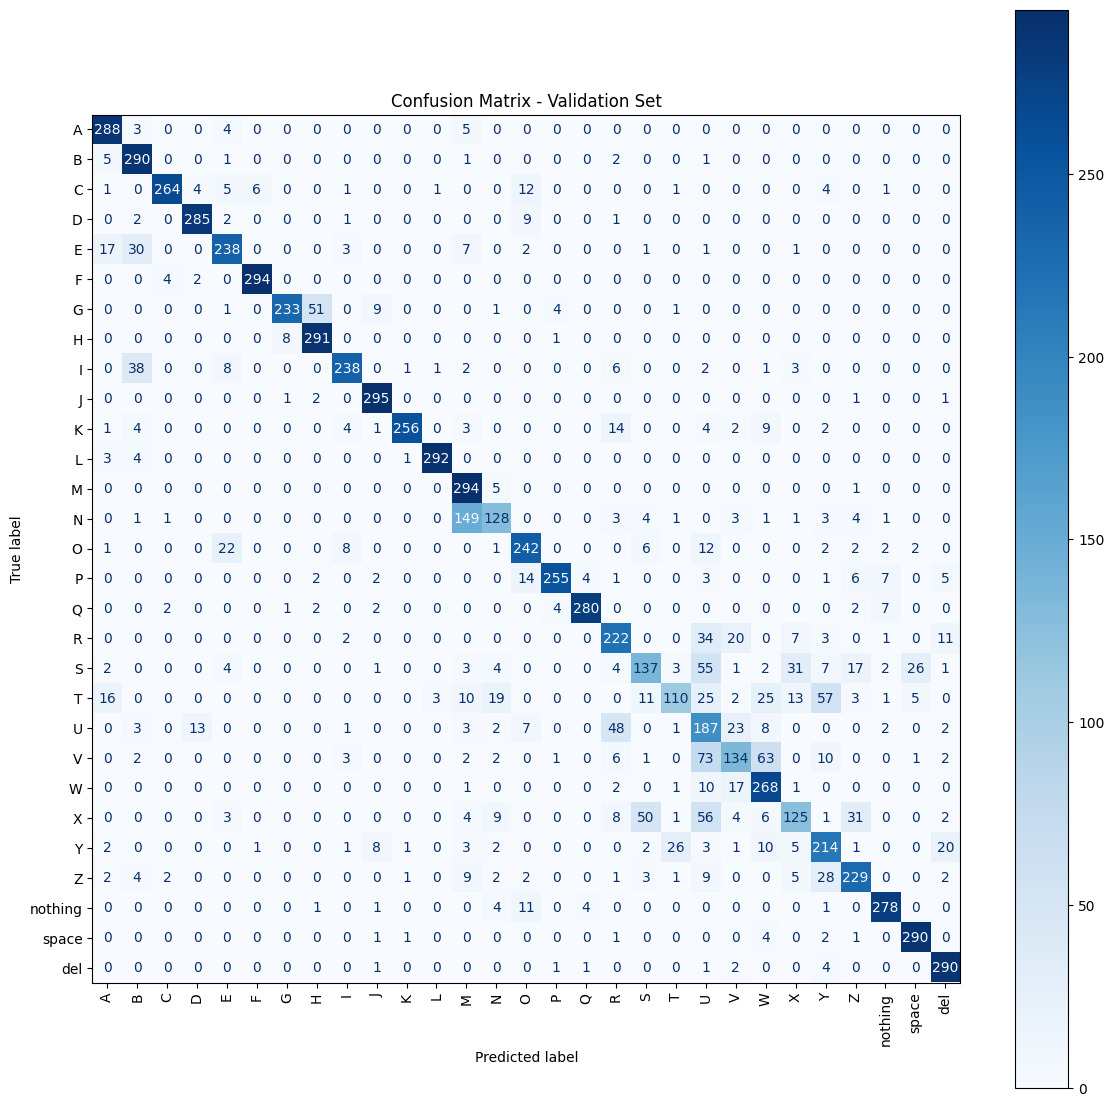


CLASSIFICATION REPORT - Validation Set
              precision    recall  f1-score   support

           A       0.85      0.96      0.90       300
           B       0.76      0.97      0.85       300
           C       0.97      0.88      0.92       300
           D       0.94      0.95      0.94       300
           E       0.83      0.79      0.81       300
           F       0.98      0.98      0.98       300
           G       0.96      0.78      0.86       300
           H       0.83      0.97      0.90       300
           I       0.91      0.79      0.85       300
           J       0.92      0.98      0.95       300
           K       0.98      0.85      0.91       300
           L       0.98      0.97      0.98       300
           M       0.59      0.98      0.74       300
           N       0.72      0.43      0.53       300
           O       0.81      0.81      0.81       300
           P       0.96      0.85      0.90       300
           Q       0.97      0.93      0.

In [12]:
# ==============================
# 6. EVALUATION ON VALIDATION SET (Generator)
# ==============================
def evaluate_generator(generator, title="Dataset"):
    # Evaluate loss and accuracy
    loss, acc = model.evaluate(generator, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    # Get predictions
    y_pred = model.predict(generator, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

# Evaluate on validation set
evaluate_generator(val_generator, title="Validation Set")

In [13]:
# ==============================
# 7. LOAD EXTERNAL TEST DATA (FIXED COLORS)
# ==============================
def load_external_test_data(test_dir, img_size=(128, 128)):
    images, labels = [], []
    
    if not os.path.exists(test_dir):
        print(f"Error: Directory {test_dir} not found.")
        return np.array([]), np.array([])

    for folder in os.listdir(test_dir):
        if folder not in classes:
            continue
            
        label_idx = classes.index(folder)
        folder_path = os.path.join(test_dir, folder)
        
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            
            # Read image
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"⚠️ Skipping unreadable file: {img_path}")
                continue
            
            # CRITICAL FIX: Convert BGR (OpenCV standard) to RGB (TensorFlow standard)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            
            images.append(img)
            labels.append(label_idx)
            
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    
    print(f"\nLoaded {images.shape[0]} external test images. Shape = {images.shape}")
    return images, labels

x_test_external, y_test_external = load_external_test_data(external_test_dir, img_size=input_shape[:2])


Loaded 870 external test images. Shape = (870, 128, 128, 3)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.2394 - loss: 7.7434

External Test Set - Accuracy: 0.2540, Loss: 6.4325
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


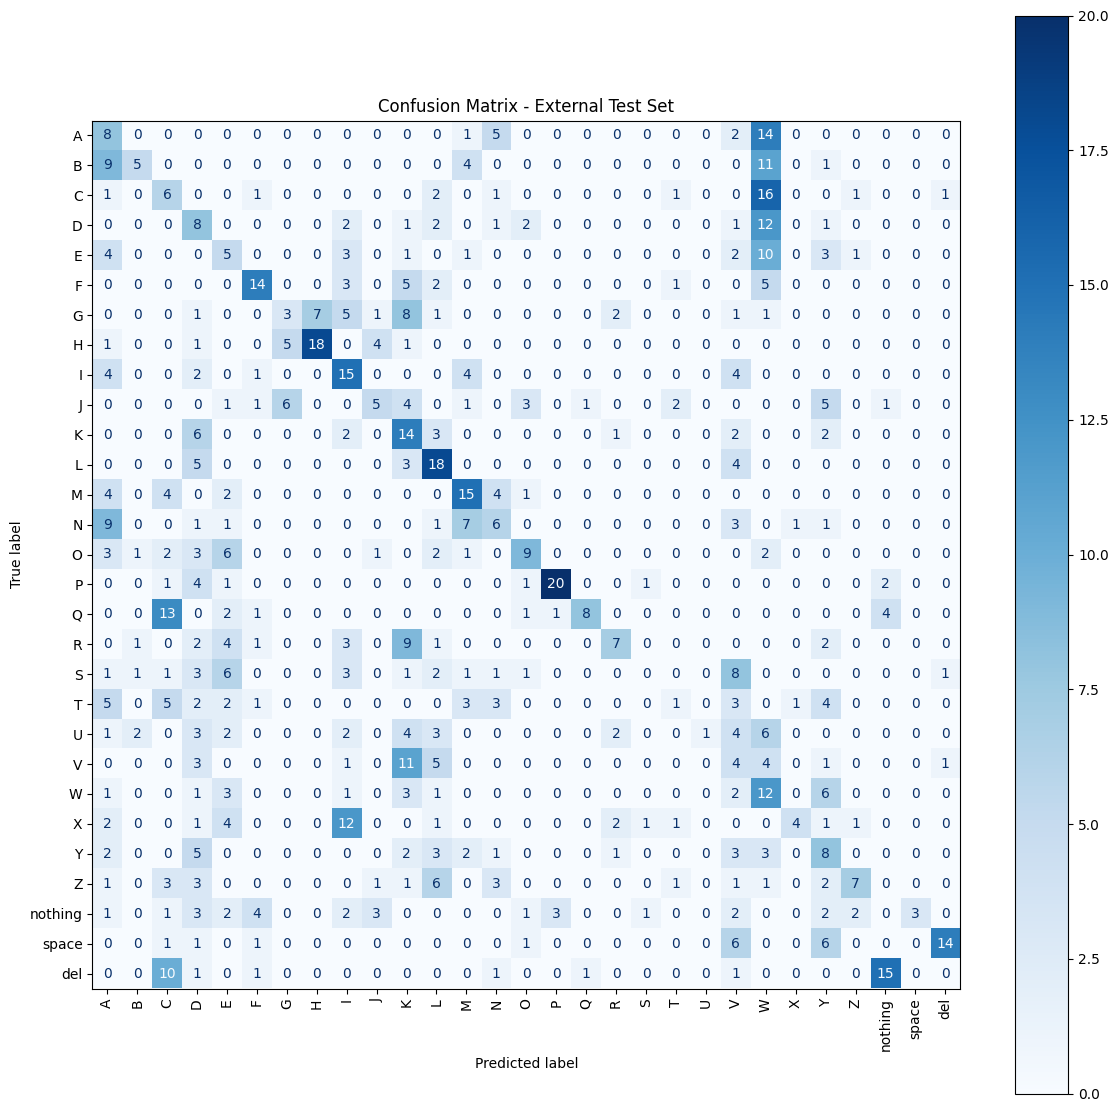


CLASSIFICATION REPORT - External Test Set
              precision    recall  f1-score   support

           A       0.14      0.27      0.18        30
           B       0.50      0.17      0.25        30
           C       0.13      0.20      0.16        30
           D       0.14      0.27      0.18        30
           E       0.12      0.17      0.14        30
           F       0.54      0.47      0.50        30
           G       0.21      0.10      0.14        30
           H       0.72      0.60      0.65        30
           I       0.28      0.50      0.36        30
           J       0.33      0.17      0.22        30
           K       0.21      0.47      0.29        30
           L       0.34      0.60      0.43        30
           M       0.38      0.50      0.43        30
           N       0.23      0.20      0.21        30
           O       0.45      0.30      0.36        30
           P       0.83      0.67      0.74        30
           Q       0.80      0.27     

In [14]:
# ==============================
# 8. EVALUATE ON EXTERNAL TEST SET (ARRAY METHOD)
# ==============================
def evaluate_on_arrays(x_data, y_data, title="External Test Set"):
    if x_data.size == 0:
        print("No data to evaluate.")
        return

    # Evaluate loss and accuracy
    loss, acc = model.evaluate(x_data, y_data, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    # Get predictions
    y_pred = model.predict(x_data, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_data, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

# Run the evaluation
evaluate_on_arrays(x_test_external, y_test_external, title="External Test Set")